# 基础知识
## 啥是Harr特征
Haar特征包含三种：边缘特征、线性特征、中心特征和对角线特征。每种分类器都从图片中提取出对应的特征。

## Harr特征

搜索人脸上的指定特征

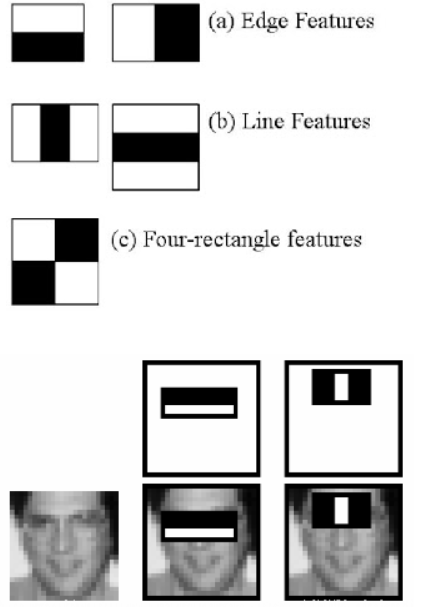

比如上图中，横的黑道将人脸中较暗的双眼提取了出来，而竖的白道将人脸中较亮的鼻梁提取了出来。

这种分类器有很像卷积核，卷积核也是从图片中提取指定特征的筛选器。

我去年制作的这个视频生动形象展示了卷积神经网络提取图片特征的整个过程

# 大白话讲解卷积神经网络工作原理

## 啥是Cascade级联分类器
基于Haar特征的cascade级联分类器是Paul Viola和 Michael Jone在2001年的论文”Rapid Object Detection using a Boosted Cascade of Simple Features”中提出的一种有效的物体检测方法。

Cascade级联分类器的训练方法：Adaboost
级联分类器的函数是通过大量带人脸和不带人脸的图片通过机器学习得到的。对于人脸识别来说，需要几万个特征，通过机器学习找出人脸分类效果最好、错误率最小的特征。训练开始时，所有训练集中的图片具有相同的权重，对于被分类错误的图片，提升权重，重新计算出新的错误率和新的权重。直到错误率或迭代次数达到要求。这种方法叫做Adaboost。

在Opencv中可以直接调用级联分类器函数。

将弱分类器聚合成强分类器
最终的分类器是这些弱分类器的加权和。之所以称之为弱分类器是因为每个分类器不能单独分类图片，但是将他们聚集起来就形成了强分类器。论文表明，只需要200个特征的分类器在检测中的精确度达到了95%。最终的分类器大约有6000个特征。(将超过160000个特征减小到6000个，这是非常大的进步了） 。

级联的含义：需过五关斩六将才能被提取出来
事实上，一张图片绝大部分的区域都不是人脸。如果对一张图片的每个角落都提取6000个特征，将会浪费巨量的计算资源。

如果能找到一个简单的方法能够检测某个窗口是不是人脸区域，如果该窗口不是人脸区域，那么就只看一眼便直接跳过，也就不用进行后续处理了，这样就能集中精力判别那些可能是人脸的区域。 为此，有人引入了Cascade 分类器。它不是将6000个特征都用在一个窗口，而是将特征分为不同的阶段，然后一个阶段一个阶段的应用这些特征(通常情况下，前几个阶段只有很少量的特征)。如果窗口在第一个阶段就检测失败了，那么就直接舍弃它，无需考虑剩下的特征。如果检测通过，则考虑第二阶段的特征并继续处理。如果所有阶段的都通过了，那么这个窗口就是人脸区域。 作者的检测器将6000+的特征分为了38个阶段，前五个阶段分别有1，10，25，25，50个特征(前文图中提到的识别眼睛和鼻梁的两个特征实际上是Adaboost中得到的最好的两个特征)。根据作者所述，平均每个子窗口只需要使用6000+个特征中的10个左右。

OpenCV中的Haar-cascade检测
OpenCV 既可以作为检测器也可以进行机器学习训练。如果你打算训练自己的分类器识别任意的物品，比如车，飞机，咖啡杯等。你可以用OpenCV 创造一个。完整的细节在:Cascade Classifier Training¶中。

下面给出调用OpenCV进行基于Haar特征的人脸和人眼Cascade级联分类器的源代码。

小试牛刀：十行代码完成人脸识别（附源代码）

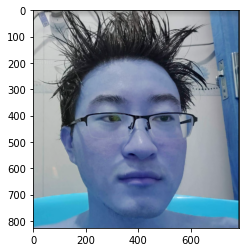

In [10]:
import cv2
import matplotlib.pyplot as plt
def original_show(image):
    

img = cv2.imread('normal.jpg',1)
plt.imshow(img)